In [76]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from nltk import FreqDist

from tqdm.auto import tqdm
import re
import contractions
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

from bs4 import MarkupResemblesLocatorWarning
import warnings

c:\Users\kiril\OneDrive\Рабочий стол\tags_classifier\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Подготовка датасета

### Чтение датасета

In [77]:
questions = pd.read_csv("dataset/Questions.csv", encoding="ISO-8859-1")
questions.head(5)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [78]:
tags = pd.read_csv("dataset/Tags.csv", encoding="ISO-8859-1")
print(f"""Unique Tags count: {tags["Tag"].unique().shape[0]}""")
tags.head(5)

Unique Tags count: 37035


,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [79]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [80]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


### Группировка и объединение тегов

In [81]:
tags["Tag"] = tags["Tag"].astype(str)
grouped_tags = tags.groupby("Id")["Tag"].apply(lambda tags: " ".join(tags))
print(grouped_tags.shape)
grouped_tags.head(10)

(1264216,)


Id
80                               flex actionscript-3 air
90          svn tortoisesvn branch branching-and-merging
120                                  sql asp.net sitemap
180       algorithm language-agnostic colors color-space
260              c# .net scripting compiler-construction
330                           c++ oop class nested-class
470                                    .net web-services
580    sql-server sql-server-2005 deployment release-...
650                          c# visual-studio versioning
810          windows visual-studio registry installation
Name: Tag, dtype: object

In [82]:
df_grouped_tags = grouped_tags.reset_index(name="Tags")
df_grouped_tags.columns = ["Id", "Tags"]
df_grouped_tags.head(5)

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


### Удаление ненужных колонок

In [83]:
questions.drop(columns=["OwnerUserId", "CreationDate", "ClosedDate", "Title"], inplace=True)
questions.head(5)

,Id,Score,Body
0,80,26,<p>I've written a database generation script i...
1,90,144,<p>Are there any really good tutorials explain...
2,120,21,<p>Has anyone got experience creating <strong>...
3,180,53,<p>This is something I've pseudo-solved many t...
4,260,49,<p>I have a little game written in C#. It uses...


### Объединение вопросов и тегов

In [84]:
data = questions.merge(df_grouped_tags, on="Id")
data.head(10)

,Id,Score,Body,Tags
0,80,26,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction
5,330,29,<p>I am working on a collection of classes use...,c++ oop class nested-class
6,470,13,<p>I've been writing a few web services for a ...,.net web-services
7,580,21,<p>I wonder how you guys manage deployment of ...,sql-server sql-server-2005 deployment release-...
8,650,79,<p>I would like the version property of my app...,c# visual-studio versioning
9,810,9,<p>I'm trying to maintain a Setup Project in <...,windows visual-studio registry installation


### Фильтрация по показателю рейтинга (Score)

#### Метрики

In [85]:
print(f"""
Minimum Score: {data["Score"].min()}
Maximum Score: {data['Score'].max()}

Total count {data["Score"].count()}
Count (Score > 0) {data[data["Score"] > 0]["Score"].count()}
Count (Score > 5) {data[data["Score"] > 5]["Score"].count()}
Count (Score > 10) {data[data["Score"] > 20]["Score"].count()}
Count (Score > 20) {data[data["Score"] > 10]["Score"].count()}

Describe:\n{data["Score"].describe()}
""")


Minimum Score: -73
Maximum Score: 5190

Total count 1264216
Count (Score > 0) 594057
Count (Score > 5) 72950
Count (Score > 10) 14114
Count (Score > 20) 32604

Describe:
count    1.264216e+06
mean     1.781537e+00
std      1.366389e+01
min     -7.300000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      5.190000e+03
Name: Score, dtype: float64



#### График распределения рейтинга

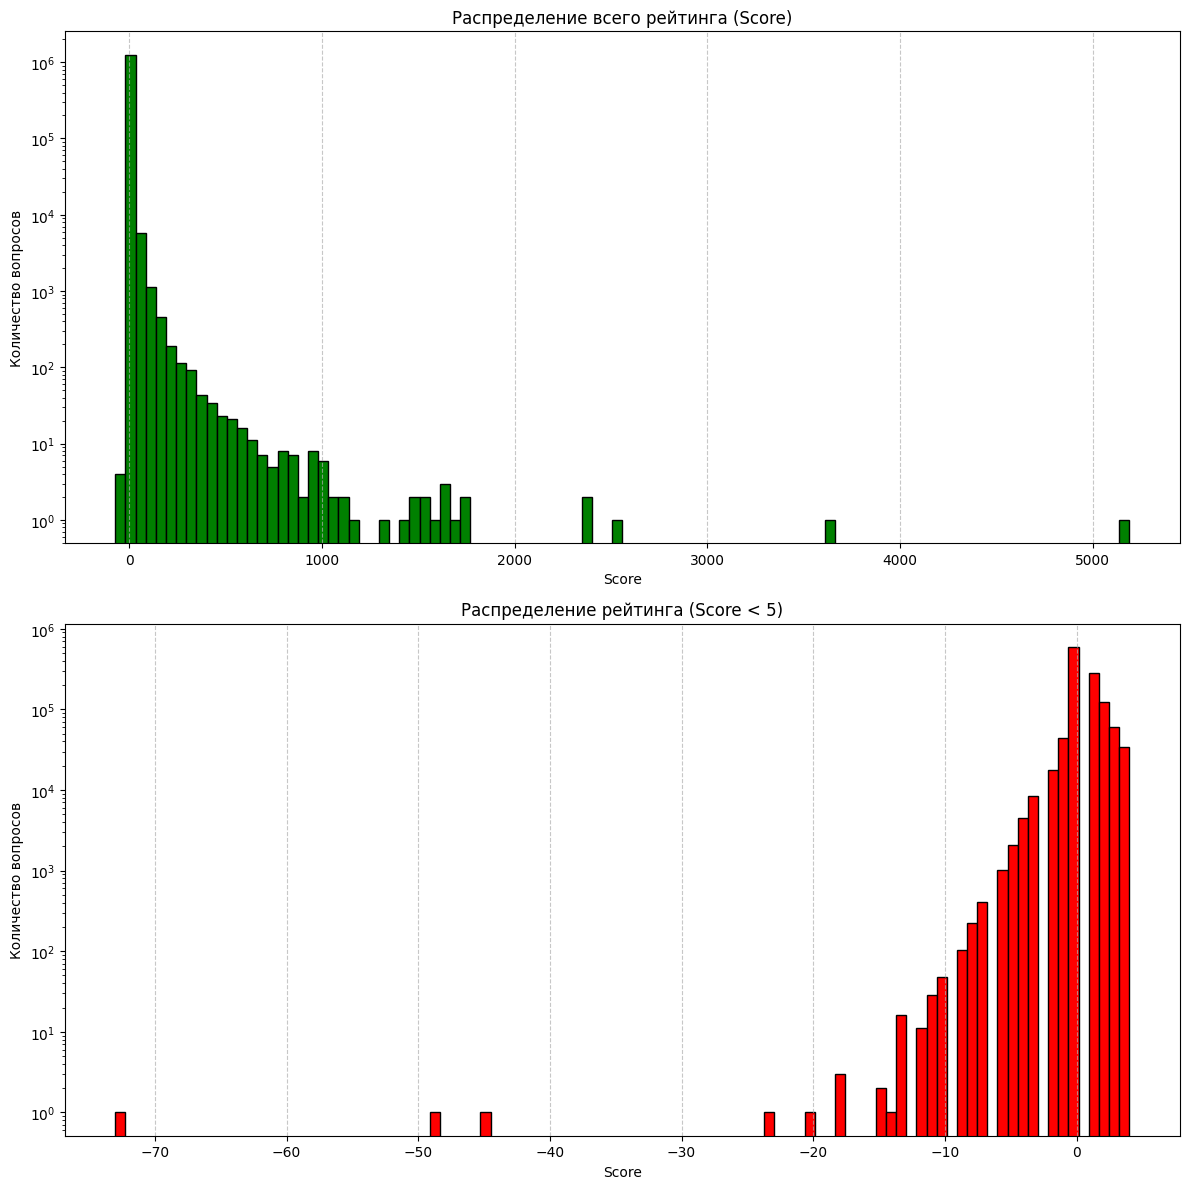

In [86]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.hist(data["Score"], bins=100, color="green", edgecolor="black")
ax1.set_title("Распределение всего рейтинга (Score)")
ax1.set_xlabel("Score")
ax1.set_ylabel("Количество вопросов")
ax1.set_yscale("log")
ax1.grid(axis="x", linestyle="--", alpha=0.7)

ax2.hist(data[data["Score"] < 5]["Score"], bins=100, color="red", edgecolor="black")
ax2.set_title("Распределение рейтинга (Score < 5)")
ax2.set_xlabel("Score")
ax2.set_ylabel("Количество вопросов")
ax2.set_yscale("log")
ax2.grid(axis="x", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

#### Удаление записей с низким показателем рейтига, удаление ненужных

In [87]:
data = data[(data["Score"] > 5) & (data["Score"] < 2000)]
data.drop(columns=["Id", "Score"], inplace=True)

print(data.shape)
print(data.info())
data.head(10)

(72945, 2)
<class 'pandas.core.frame.DataFrame'>
Index: 72945 entries, 0 to 1264205
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    72945 non-null  object
 1   Tags    72945 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB
None


,Body,Tags
0,<p>I've written a database generation script i...,flex actionscript-3 air
1,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction
5,<p>I am working on a collection of classes use...,c++ oop class nested-class
6,<p>I've been writing a few web services for a ...,.net web-services
7,<p>I wonder how you guys manage deployment of ...,sql-server sql-server-2005 deployment release-...
8,<p>I would like the version property of my app...,c# visual-studio versioning
9,<p>I'm trying to maintain a Setup Project in <...,windows visual-studio registry installation


### Подготовка заголовка и описания

#### Изначальный вид описания


In [88]:
for idx, text in data["Body"].head(5).items():
    print(f"=== Запись {idx} ===")
    print(text[:200] + "...")
    print("\n")

=== Запись 0 ===
<p>I've written a database generation script in <a href="http://en.wikipedia.org/wiki/SQL">SQL</a> and want to execute it in my <a href="http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime">Adobe AI...


=== Запись 1 ===
<p>Are there any really good tutorials explaining <a href="http://svnbook.red-bean.com/en/1.8/svn.branchmerge.html" rel="nofollow">branching and merging</a> with Apache Subversion? </p>

<p>All the be...


=== Запись 2 ===
<p>Has anyone got experience creating <strong>SQL-based ASP.NET</strong> site-map providers?</p>

<p>I've got the default XML file <code>web.sitemap</code> working properly with my Menu and <strong>Si...


=== Запись 3 ===
<p>This is something I've pseudo-solved many times and never quite found a solution. That's stuck with me. The problem is to come up with a way to generate <code>N</code> colors, that are as distingui...


=== Запись 4 ===
<p>I have a little game written in C#. It uses a database as back-end. It's 
a <a href="htt

#### Инициализация зависимостей и настройка NLTK

In [89]:
tqdm.pandas()

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

nltk.data.path.append("/home/ql/nltk_data") 

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("""
            FAILED (btw)
          """)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kiril\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kiril\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kiril\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kiril\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#### Конвейер обработки

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punct = set('!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~')

def preprocess_text(text: str) -> str:
    """
    предобработка текста:
    1. удаление HTML-тегов
    2. расширение сокращений
    3. удаление спецсимволов и цифр
    4. лемматизация
    5. удаление стоп-слов
    """
    if pd.isna(text):
        return ""
    if not isinstance(text, str) or text.strip() == '':
        return ''
    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    text = contractions.fix(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = word_tokenize(text)
    processed = [
        lemmatizer.lemmatize(token, pos='v')
        for token in tokens
        if token not in stop_words and token not in punct
    ]
    return ' '.join(processed)

#### Обработка

In [91]:
tqdm.pandas(desc=f"Processing Body")
data["Body"] = data["Body"].progress_apply(preprocess_text)

data = data.dropna(subset=["Body", "Tags"], how="any")
print(data[data["Body"].isnull()].count())
print(data[data["Tags"].isnull()].count())

data.info()

Processing Body: 100%|██████████| 72945/72945 [02:58<00:00, 408.25it/s]


Body    0
Tags    0
dtype: int64
Body    0
Tags    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 72945 entries, 0 to 1264205
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    72945 non-null  object
 1   Tags    72945 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


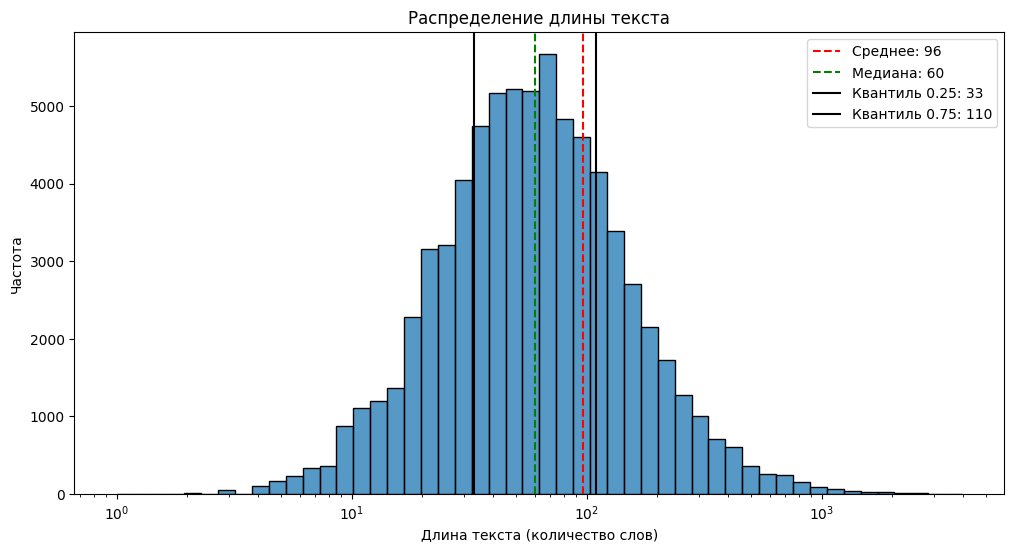

count    72945.000000
mean        93.333621
std        130.696637
min          1.000000
25%         32.000000
50%         58.000000
75%        107.000000
max       3960.000000
Name: Body, dtype: float64


In [92]:
import seaborn as sns
body_len = data["Body"].apply(lambda x: x.split(" ")).apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(body_len, bins=50, log_scale=True)
plt.title("Распределение длины текста")
plt.xlabel("Длина текста (количество слов)")
plt.ylabel("Частота")
plt.axvline(96, color="red", linestyle="--", label=f"Среднее: 96")
plt.axvline(60, color="green", linestyle="--", label=f"Медиана: 60")
plt.axvline(33, color="black", linestyle="-", label=f"Квантиль 0.25: 33")
plt.axvline(110, color="black", linestyle="-", label=f"Квантиль 0.75: 110")
plt.legend()
plt.show()

print(body_len.describe())

In [93]:
data = data[(data["Body"].apply(lambda x: x.split(" ")).apply(len) >= 33) & (data["Body"].apply(lambda x: x.split(" ")).apply(len) <= 110)]

data["Body"] = data["Body"].fillna("")

filtered_data = data[
    (data["Body"].str.len().fillna(0) > 0)
]

data.dropna(subset=["Body", "Tags"], how="any")
data = data[data["Body"].apply(len) != 0]

data

,Body,Tags
2,anyone get experience create sql base asp net ...,sql asp.net sitemap
4,little game write c use database back end trad...,c# .net scripting compiler-construction
5,work collection class use video playback recor...,c++ oop class nested-class
8,would like version property application increm...,c# visual-studio versioning
9,try maintain setup project visual studio yes l...,windows visual-studio registry installation
...,...,...
1260719,think could make python code simpler directly ...,python python-2.7 indexing generator yield
1261621,state namespace udecl use declaration name con...,c++ c++11 language-lawyer default-constructor ...
1261840,create dummy timeseries xts object miss data d...,r time-series xts zoo
1262332,follow example code class public static int in...,c++ static static-members


#### Итог

In [94]:
for idx, text in data["Body"].head(5).items():
    print(f"=== Запись {idx} ===")
    print(text[:200] + "...")
    print("\n")

=== Запись 2 ===
anyone get experience create sql base asp net site map providers get default xml file web sitemap work properly menu sitemappath control need way users site create modify page dynamically need tie pag...


=== Запись 4 ===
little game write c use database back end trade card game want implement function card script mean essentially interface icard card class implement public class card icard contain function call game m...


=== Запись 5 ===
work collection class use video playback record one main class act like public interface methods like play stop pause record etc workhorse class video decode video encode learn existence nest class c ...


=== Запись 8 ===
would like version property application incremented build sure enable functionality visual studio try specify assemblyversion get exactly want also use settings file earlier attempt assembly version c...


=== Запись 9 ===
try maintain setup project visual studio yes legacy application problem moment need write r

### Определение классов

In [95]:
data["Tags"] = data["Tags"].apply(lambda x: x.split())
data.head(10)

,Body,Tags
2,anyone get experience create sql base asp net ...,"[sql, asp.net, sitemap]"
4,little game write c use database back end trad...,"[c#, .net, scripting, compiler-construction]"
5,work collection class use video playback recor...,"[c++, oop, class, nested-class]"
8,would like version property application increm...,"[c#, visual-studio, versioning]"
9,try maintain setup project visual studio yes l...,"[windows, visual-studio, registry, installation]"
11,need grab base encode representation viewstate...,"[c#, asp.net]"
14,use ccnet sample project svn source control cc...,"[svn, msbuild, cruisecontrol.net]"
16,use msbuild build stuff want use cruisecontrol...,"[.net, .net-3.5, msbuild, nant]"
17,set dedicate sql server box windows server wee...,"[sql-server, windows-server-2008]"
19,add column table microsoft sql server control ...,[sql-server]


In [ ]:
flat_series = data["Tags"].explode()

unique_tags_count = flat_series.nunique()
tag_counts = flat_series.value_counts()
total_tags = flat_series.count()

print(f"Total tags: {total_tags}")
print(f"Unique tags: {unique_tags_count}")
print(tag_counts.head(10))

Total tags: 114104
Unique tags: 10924
Tags
c#            3520
java          3272
javascript    2940
python        2312
c++           2292
android       2209
php           1516
jquery        1467
ios           1446
.net          1337
Name: count, dtype: int64


In [97]:
COMMON_TAGS_COUNT = 33
keywords = FreqDist(flat_series)
tags_features = [word[0] for word in keywords.most_common(COMMON_TAGS_COUNT)]

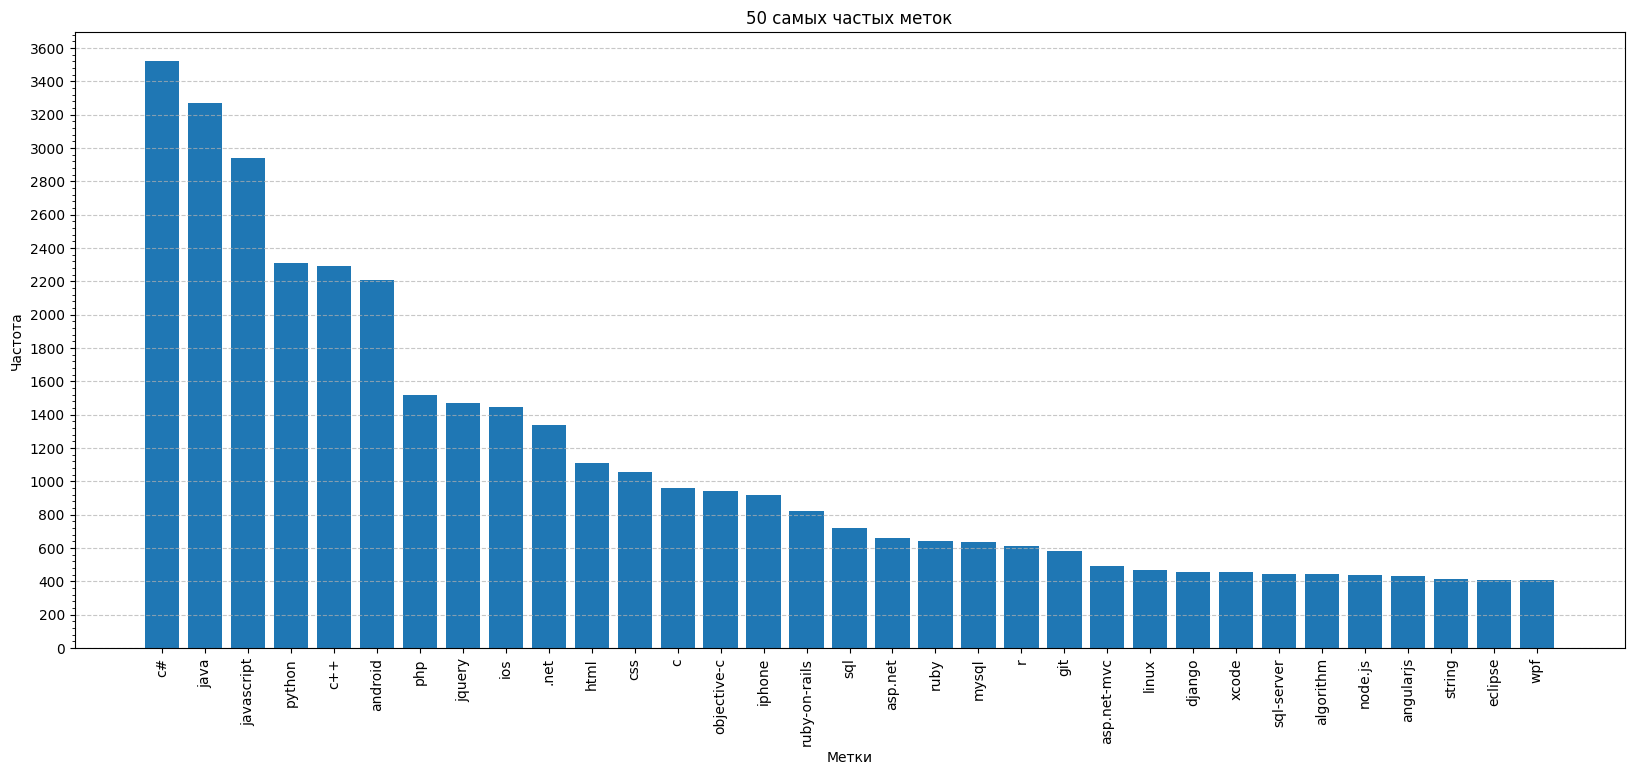

In [98]:
fig, ax = plt.subplots(figsize=(20, 8))

labels, frequencies = zip(*keywords.most_common(COMMON_TAGS_COUNT))
ax.bar(range(len(labels)), frequencies)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)

ax.yaxis.set_major_locator(ticker.MaxNLocator(20)) 
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.title('50 самых частых меток')
plt.xlabel('Метки')
plt.ylabel('Частота')
plt.show()

In [99]:
tags_features_set = set(tags_features)

mask = data["Tags"].apply(lambda tags: any(tag in tags_features_set for tag in tags))
filtered_data = data[mask].copy()

filtered_data["Tags"] = filtered_data["Tags"].apply(
    lambda tags: [tag for tag in tags if tag in tags_features_set]
)

data = filtered_data[filtered_data["Tags"].apply(len) > 0]

print(f"""
    Average tags in question: {filtered_data["Tags"].apply(len).mean()}
    Max tags in question: {filtered_data["Tags"].apply(len).max()}

    Average body length in question: {filtered_data["Body"].apply(lambda x: x.split(" ")).apply(len).mean()}
    Min body length in question: {filtered_data["Body"].apply(lambda x: x.split(" ")).apply(len).min()}
    Max body length in question: {filtered_data["Body"].apply(lambda x: x.split(" ")).apply(len).max()}
""")

data.to_csv("processed_dataset/processed_questions.csv", index=False)

data


    Average tags in question: 1.309429801159606
    Max tags in question: 5

    Average body length in question: 63.33994948955999
    Min body length in question: 33
    Max body length in question: 110



,Body,Tags
2,anyone get experience create sql base asp net ...,"[sql, asp.net]"
4,little game write c use database back end trad...,"[c#, .net]"
5,work collection class use video playback recor...,[c++]
8,would like version property application increm...,[c#]
11,need grab base encode representation viewstate...,"[c#, asp.net]"
...,...,...
1260719,think could make python code simpler directly ...,[python]
1261621,state namespace udecl use declaration name con...,[c++]
1261840,create dummy timeseries xts object miss data d...,[r]
1262332,follow example code class public static int in...,[c++]


In [106]:
print(keywords.most_common(COMMON_TAGS_COUNT))

[('c#', 3520), ('java', 3272), ('javascript', 2940), ('python', 2312), ('c++', 2292), ('android', 2209), ('php', 1516), ('jquery', 1467), ('ios', 1446), ('.net', 1337), ('html', 1111), ('css', 1056), ('c', 958), ('objective-c', 943), ('iphone', 919), ('ruby-on-rails', 819), ('sql', 717), ('asp.net', 658), ('ruby', 639), ('mysql', 633), ('r', 610), ('git', 582), ('asp.net-mvc', 492), ('linux', 466), ('django', 456), ('xcode', 453), ('sql-server', 445), ('algorithm', 443), ('node.js', 440), ('angularjs', 434), ('string', 416), ('eclipse', 406), ('wpf', 405)]


## Обучение модели

In [1]:
from ast import literal_eval

from tensorflow import keras
from tensorflow.keras import Model, regularizers, metrics, layers, optimizers, callbacks

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

import pickle
import pandas as pd

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

# tf.config.threading.set_intra_op_parallelism_threads(4)
# tf.config.threading.set_inter_op_parallelism_threads(4)

### Подготовка данных

In [2]:
data = pd.read_csv("processed_dataset/processed_questions.csv", encoding="ISO-8859-1",
    dtype={
        "Body": str
    },
    converters={
        "Tags": lambda x: literal_eval(x)
    }
)

data["Body"] = data["Body"].fillna("")

data = data[
    data["Body"].str.len().fillna(0) > 0
]

In [3]:
X = data['Body']
Y = data['Tags']

In [4]:
MAX_FEATURES_BODY = 1280
TOTAL_FEATURES = MAX_FEATURES_BODY

vectorizer_X = TfidfVectorizer(
    analyzer = 'word',
    min_df=150,
    max_df = 1.0,
    encoding = 'utf-8',
    ngram_range=(1, 2),
    token_pattern=r"(?u)\S\S+",
    max_features=MAX_FEATURES_BODY,
)

X_tfidf = vectorizer_X.fit_transform(X)

pickle.dump(vectorizer_X, open("vectorizers/BodyVectorizer.pickle", "wb"))

TOTAL_FEATURES = len(vectorizer_X.get_feature_names_out())

multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(Y)

In [ ]:
TEST_SPLIT_FRACTION = 0.2

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size=TEST_SPLIT_FRACTION, random_state=0)

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(22490, 1280)
(22490, 33)
(5623, 1280)
(5623, 33)


### Обучение моделей

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(10, 7))
    
    metrics = [
        ('loss', 'val_loss'),
        ('auc', 'val_auc'),
        ('recall', 'val_recall'),
        ('precision', 'val_precision'),
    ]
    
    for i, (metric, val_metric) in enumerate(metrics):
        plt.subplot(3, 2, i+1)
        
        plt.plot(history.history[metric], label=f'Training {metric}')
        
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label=f'Validation {metric}')
        
        plt.title(metric.upper())
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)

    plt.subplot(3, 2, 5)
    plt.plot(history.history["recall"], history.history["precision"], label="Precision / recall")
    plt.title("Pecision / recall")
    plt.xlabel('recall')
    plt.ylabel("precision")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def check_model(model):
    print(model.evaluate(X_test , y_test))

In [8]:
COMMON_TAGS_COUNT = 33
EPOCHS_COUNT = 2

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 1280)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_78 (Dense)    │ (None, 768)       │    983,808 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 768)       │      3,072 │ dense_78[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, 768)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_80 (Dense)    │ (None, 512)       │    393,728 │ dropout_52[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_80[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_81 (Dense)    │ (None, 384)       │    196,992 │ dropout_53[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 384)       │      1,536 │ dense_81[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_54          │ (None, 384)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_79 (Dense)    │ (None, 384)       │    295,296 │ dropout_52[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 384)       │          0 │ dropout_54[0][0], │
│                     │                   │            │ dense_79[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_82 (Dense)    │ (None, 256)       │     98,560 │ add_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_83 (Dense)    │ (None, 33)        │      8,481 │ dense_82[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,983,521 (7.57 MB)

 Trainable params: 1,980,193 (7.55 MB)

 Non-trainable params: 3,328 (13.00 KB)

Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - auc: 0.6224 - f1: 0.0839 - loss: 369.3733 - precision: 0.0477 - recall: 0.7782 - val_auc: 0.7597 - val_f1: 0.0956 - val_loss: 163.2293 - val_precision: 0.0448 - val_recall: 0.9783
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 66ms/step - auc: 0.8789 - f1: 0.1289 - loss: 139.7463 - precision: 0.0793 - recall: 0.9331 - val_auc: 0.9358 - val_f1: 0.1969 - val_loss: 50.3354 - val_precision: 0.1049 - val_recall: 0.9714
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - auc: 0.9256 - f1: 0.2457 - loss: 55.4917 - precision: 0.1482 - recall: 0.9107 - val_auc: 0.9466 - val_f1: 0.4620 - val_loss: 34.0540 - val_precision: 0.2740 - val_recall: 0.8543
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - auc: 0.9416 - f1: 0.4697 - loss: 41.2463 - precision: 0.3062 - recall: 0.8073 - val_auc: 0.9540 - val_f1: 0.5661 - val_loss: 28.7569 - val_precision: 0.4547 - val_recall: 0.7236
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 66ms/step - auc: 

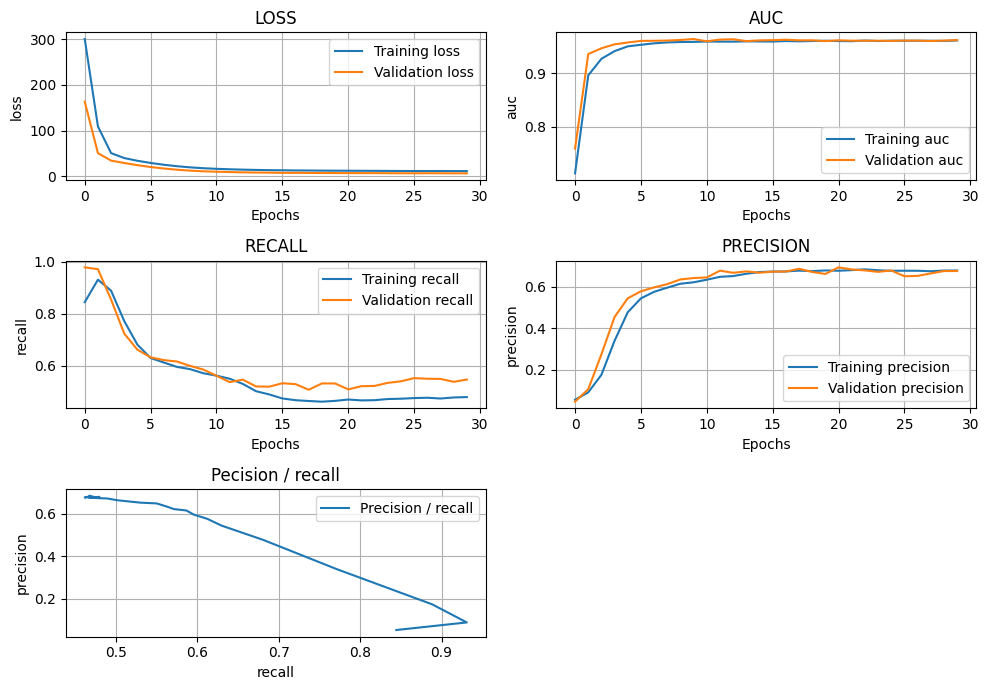

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.losses import CategoricalFocalCrossentropy 

def balanced_class_weights(y, recall_factor=1.5, max_weight=5.0):
    class_weights = {}
    num_classes = y.shape[1]
    
    for class_idx in range(num_classes):
        class_labels = y[:, class_idx]
        pos_count = np.sum(class_labels)
        neg_count = len(class_labels) - pos_count
        
        weight_positive = min(max_weight, 
                            (neg_count / (pos_count + 1e-6))**0.5 * recall_factor)
        class_weights[class_idx] = weight_positive
 
    return class_weights

class_weights_dict = balanced_class_weights(y_train, recall_factor=1.4, max_weight=8.0)

def build_model():
    inputs = tf.keras.Input(shape=(TOTAL_FEATURES,))
    
    x = layers.Dense(768, activation='swish', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    residual = layers.Dense(384, activation='swish', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))(x)
    
    x = layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.001, l2=0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(384, activation='swish', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.001, l2=0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Add()([x, residual])
    x = layers.Dense(256, activation='swish', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1_l2(0.001))(x)

    outputs = layers.Dense(COMMON_TAGS_COUNT, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = optimizers.AdamW(
        learning_rate=1e-4,
    )
    
    model.compile(
        optimizer=optimizer,
        loss=CategoricalFocalCrossentropy(
            alpha=0.65,
            gamma=1.4,
            from_logits=False,
        ),
        metrics=[
            metrics.Recall(name='recall', thresholds=0.4),
            metrics.Precision(name='precision', thresholds=0.4),
            metrics.AUC(name='auc'),
            metrics.F1Score(name='f1', threshold=0.4)
        ]
    )
    
    return model

model = build_model()

model.summary()

history = model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict,
    batch_size=64,
)

model.save("fit_history/model_11.keras")
np.save("fit_history/hist_11", history)

check_model(model)
plot_training_history(history)

Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - auc: 0.9672 - f1: 0.5606 - loss: 7.5092 - precision: 0.6992 - recall: 0.4887 - val_auc: 0.9619 - val_f1: 0.5945 - val_loss: 3.0456 - val_precision: 0.6834 - val_recall: 0.5377
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - auc: 0.9674 - f1: 0.5571 - loss: 7.4566 - precision: 0.6948 - recall: 0.4845 - val_auc: 0.9614 - val_f1: 0.5946 - val_loss: 3.0191 - val_precision: 0.6788 - val_recall: 0.5426
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - auc: 0.9679 - f1: 0.5643 - loss: 7.4178 - precision: 0.6927 - recall: 0.4873 - val_auc: 0.9615 - val_f1: 0.5961 - val_loss: 2.9991 - val_precision: 0.6794 - val_recall: 0.5418
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - auc: 0.9687 - f1: 0.5668 - loss: 7.3005 - precision: 0.6956 - recall: 0.4893 - val_auc: 0.9619 - val_f1: 0.5978 - val_loss: 2.9684 - val_precision: 0.6741 - val_recall: 0.5477
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - auc: 0.9667 - f1

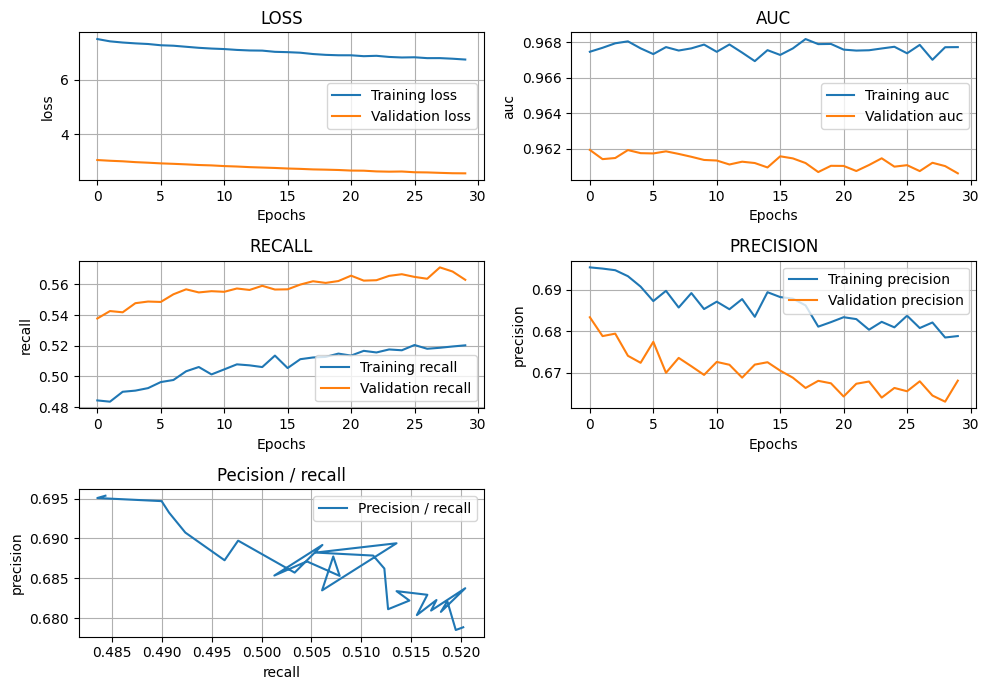

In [26]:
model = keras.models.load_model("fit_history/model_11.keras")

for layer in model.layers[:8]:
    layer.trainable = False

history = model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict,
    batch_size=64,
)

model.save("fit_history/model_11_1.keras")
np.save("fit_history/hist_11_1", history)

check_model(model)
plot_training_history(history)

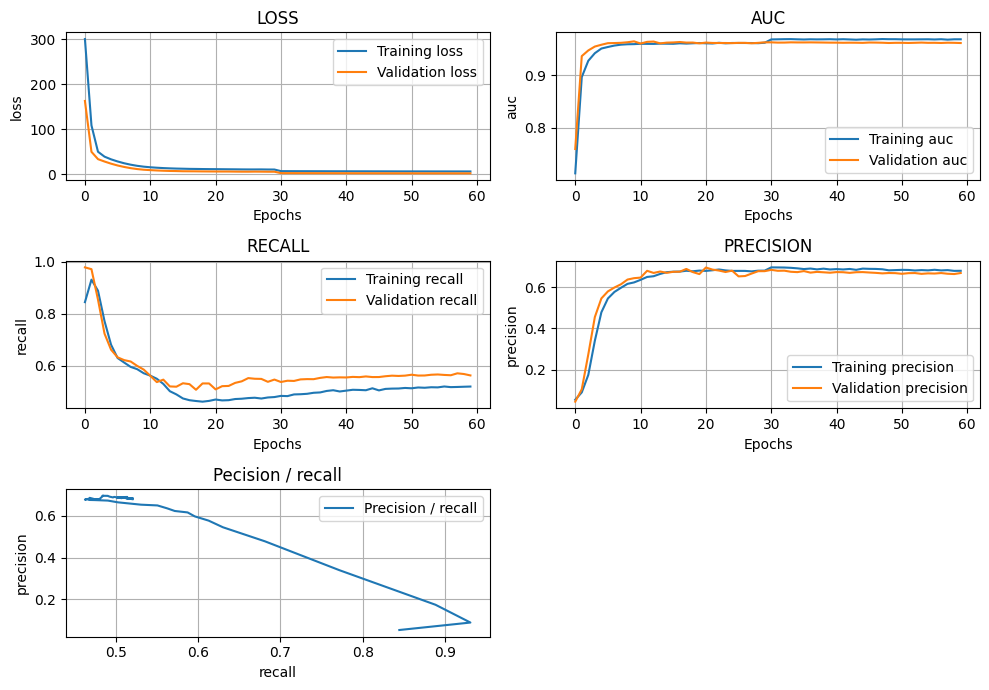

In [63]:
import numpy as np
import matplotlib.pyplot as plt

def load_combined_history(hist_path1, hist_path2):
    hist1 = np.load(hist_path1, allow_pickle=True).item()
    hist2 = np.load(hist_path2, allow_pickle=True).item()
    
    combined_hist = {}
    for key in hist1.history.keys():
        if key in hist2.history:
            combined_hist[key] = np.concatenate((hist1.history[key], hist2.history[key]), axis=None)
    
    class CombinedHistory:
        def __init__(self, history):
            self.history = history
    
    return CombinedHistory(combined_hist)

combined_history = load_combined_history(
    'fit_history/hist_11.npy',
    'fit_history/hist_11_1.npy'
)

plot_training_history(combined_history)

## Результаты обучения

In [1]:
import pandas as pd 
from ast import literal_eval

from nltk import FreqDist


data = pd.read_csv("processed_dataset/processed_questions.csv", encoding="ISO-8859-1", converters={
        "Tags": lambda x: literal_eval(x)
    })

flat_series = data['Tags'].explode()

keywords = FreqDist(flat_series)

In [10]:
COMMON_TAGS_COUNT = 33

for i in range(7):
    for tag, count in keywords.most_common(COMMON_TAGS_COUNT)[i*5:(i+1)*5]:
        print(f"{tag}: {count}", end="\t\t")
    print()

c#: 3520		java: 3272		javascript: 2940		python: 2312		c++: 2292		
android: 2209		php: 1516		jquery: 1467		ios: 1446		.net: 1337		
html: 1111		css: 1056		c: 958		objective-c: 943		iphone: 919		
ruby-on-rails: 819		sql: 717		asp.net: 658		ruby: 639		mysql: 633		
r: 610		git: 582		asp.net-mvc: 492		linux: 466		django: 456		
xcode: 453		sql-server: 445		algorithm: 443		node.js: 440		angularjs: 434		
string: 416		eclipse: 406		wpf: 405		


In [11]:
from tensorflow import keras
import joblib
from scipy.sparse import hstack


vectorizer_X1 = joblib.load("vectorizers/BodyVectorizer.pickle")
multilabel_binarizer = joblib.load("vectorizers/TagsVectorizer.pickle")

2025-05-29 20:15:08.794000: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-29 20:15:08.900050: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-29 20:15:08.976645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748538909.057260   86262 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748538909.080520   86262 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748538909.241259   86262 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [20]:
TITLE = """Make some buttons on frontend"""
BODY = """    
Create a button, which will use jQuery javascript script
"""

TITLE = """Fix user profile page"""
BODY = """    
Rewrite our python untyped backend view, which calculate user bonus amount, maybe fix celery, maybe it broke crontab 
"""

# TITLE = """Refactor Backend Integration for Data Export"""
# BODY = """
# The current CSV export in PyQt5 blocks the UI thread.  
# - Move export logic to a QThread worker.  
# - Replace string concatenation with pandas DataFrame for CSV generation.  
# - Add error handling for invalid data (show QMessageBox on failure).  
# - Allow cancellation via a "Stop Export" button.  """

# TITLE = """Optimize Slow Customer Orders Query"""
# BODY = """
# The query fetching customer orders (JOIN on `customers`, `orders`, `products`) takes 15+ seconds.  
# - Analyze the execution plan with `EXPLAIN ANALYZE`.  
# - Add missing indexes (suggest candidates: `orders.customer_id`, `products.sku`).  
# - Rewrite the query to avoid correlated subqueries.  
# - Partition the `orders` table by `order_date` (YYYY-MM).  
# - Validate speed improvement (target: <1s).  
# """

# TITLE = """Dynamically added jQuery elements not triggering click events"""
# BODY = """I'm using jQuery to add new buttons to a div with append(), but the click events don't work on the new elements. My code:
# javascript
# Copy

# $('#container').append('<button class='btn'>Click me</button>');  
# $('.btn').on('click', () => alert('Button clicked'));  

# # Events work on initial buttons but not dynamically added ones. How can I fix this?"""

# TITLE = """RecyclerView not updating after adding new items in Android"""
# BODY = """
# I have a RecyclerView adapter that updates a list of data. After calling adapter.add(newItem) and adapter.notifyDataSetChanged(), the UI doesn't refresh. 
# My code uses ListAdapter with DiffUtil. What am I missing? Is there a threading issue?
# """

# TITLE = """Fix Cross-Platform Layout Issues in Flutter App"""  
# BODY = """  
# UI renders differently on iOS/Android devices (text overflow, alignment).  
# - Replace hardcoded sizes with MediaQuery-based layout.  
# - Implement platform-aware ThemeData (Cupertino/Material).  
# - Add golden tests for critical screens.  
# - Use Flex widgets instead of Row/Column nesting.  
# - Verify font scaling (1.0-2.0) accessibility requirements.  
# """


# TITLE = """Secure API Endpoints Against SQL Injection"""  
# BODY = """  
# Raw SQL queries in ASP.NET Core 6 controllers are vulnerable to injection.  
# - Replace string concatenation with Entity Framework parameterization.  
# - Add Dapper's `DynamicParameters` for complex queries.  
# - Implement regex filter for suspicious characters in request params.  
# - Create automated tests with SQLMAP test cases.  
# - Add rate limiting (max 5 req/sec) to brute-force endpoints.  
# """

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Predicted tags: [('python',)]
Predicted tags (top 10): ['python' 'algorithm' 'django' 'string' 'java' 'ruby' 'ios' 'objective-c'
 'c' 'c++']


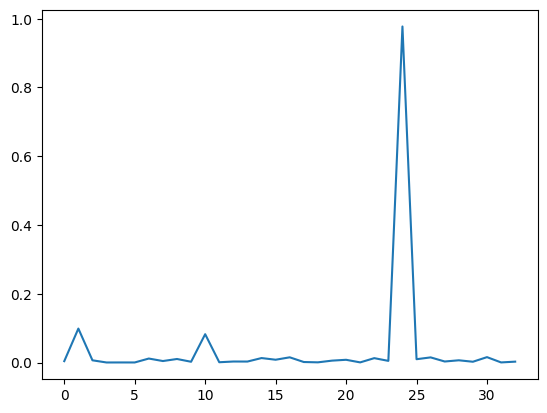

In [ ]:
import heapq

def get_top_ten(arr: list[float]):
    h = []
    for i, val in enumerate(arr):
        h.append((-val, [i, val]))
    heapq.heapify(h)

    res = []
    for i in range(10):
        res.append(heapq.heappop(h)[1])

    return res

X_input = vectorizer_X1.transform([BODY])


model = keras.models.load_model("fit_history/model_11_1.keras")

probas = model.predict(X_input)

print("Predicted tags:", multilabel_binarizer.inverse_transform((probas > 0.20).astype(int)))
print("Predicted tags (top 10):", multilabel_binarizer.classes_[[t for t, _ in get_top_ten(probas[0])]])

import matplotlib.pyplot as plt

plt.plot(probas[0])
